In [1]:
import torch
import torch.utils.data as data
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

DATA UTILS

In [2]:
# The 'reduce_dataset' function reduces the size of a given dataset.
# It can ensure balanced class representation if required.
def reduce_dataset(dataloader, percentage, balanced=True, seed=42):

    """
    Reduces the dataset to the given percentage. Can ensure class balance if needed.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - balanced: If True, ensures class balance. If False, reduces randomly.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset

    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    if not balanced:
        # Determine the number of samples to keep
        num_samples = int(len(dataset) * percentage)

        # Randomly select indices without replacement
        indices = torch.randperm(len(dataset))[:num_samples].tolist()

    else:
        # Get unique classes and their counts
        classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)

        # Determine the number of samples per class to keep
        num_samples_per_class = int(len(dataset) * percentage / len(classes))
        indices = []

        for class_label in classes:
            class_indices = [i for i, label in enumerate(y) if label == class_label]

            # Randomly select indices without replacement for each class
            class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
            indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset.
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

# 'RelabeledSubset' is used to remap labels in a dataset
class RelabeledSubset(torch.utils.data.Dataset):
    """
    A dataset wrapper that applies a new label mapping to a given dataset.

    Parameters:
    - dataset (Dataset): The original dataset.
    - label_map (dict): A dictionary mapping original labels to new labels.
    """
    def __init__(self, dataset, label_map):
        self.dataset = dataset
        self.label_map = label_map

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        label = self.label_map[label]  # Remap label
        return data, label

    def __len__(self):
        return len(self.dataset)

# Class for managing the FashionMNIST dataset for transfer learning
class TransferLearningFashionMNIST(object):
    """
    Prepares the FashionMNIST dataset for transfer learning, dividing it into pretraining and fine-tuning datasets.

    Parameters:
    - batch_size (int): Batch size for data loaders.
    - input_dim (int): The dimensionality of the input data.
    - val_split (float): The proportion of validation data.
    - num_workers (int): Number of workers for data loaders.
    - seed (int): Seed for random operations.
    """
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1, num_workers=0, seed=42):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return torch.utils.data.Subset(dataset, indices)

        fashion_train_data = datasets.FashionMNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        # Filter datasets
        pretrain_classes = [0, 1, 2, 3, 4, 6, 8]
        finetune_classes = [5, 7, 9]
        pretrain_data = filter_dataset(fashion_train_data, pretrain_classes)
        finetune_data = filter_dataset(fashion_train_data, finetune_classes)

        # Split datasets into train and validation sets
        pretrain_len = len(pretrain_data)
        finetune_len = len(finetune_data)
        pretrain_val_len = int(val_split * pretrain_len)
        finetune_val_len = int(val_split * finetune_len)

        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(seed))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(seed))

        # Label maps for relabeling
        pretrain_label_map = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 6: 5, 8: 6}
        finetune_label_map = {5: 0, 7: 1, 9: 2}

        # Apply RelabeledSubset to split sets
        pretrain_train_set = RelabeledSubset(pretrain_train_set, pretrain_label_map)
        pretrain_val_set = RelabeledSubset(pretrain_val_set, pretrain_label_map)
        finetune_train_set = RelabeledSubset(finetune_train_set, finetune_label_map)
        finetune_val_set = RelabeledSubset(finetune_val_set, finetune_label_map)

        # Creating dataloaders
        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Load and process test data
        fashion_test_data = datasets.FashionMNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(fashion_test_data, pretrain_classes)
        finetune_test_data = filter_dataset(fashion_test_data, finetune_classes)

        # Apply RelabeledSubset to test datasets
        pretrain_test_data = RelabeledSubset(pretrain_test_data, pretrain_label_map)
        finetune_test_data = RelabeledSubset(finetune_test_data, finetune_label_map)

        # Creating dataloaders for test sets
        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Complete test loader contains all test examples.
        self.complete_test_loader = torch.utils.data.DataLoader(fashion_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

class TransferLearningFashionMNISTWrapper:
    """
    This wrapper class provides a convenient way to switch between pretraining and fine-tuning phases.

    It allows for changing the phase and accordingly updating the data loaders (train, val, test)
    to either pretraining or fine-tuning sets.
    """
    def __init__(self, TransferLearningFashionMNISTObj, phase):
        """
        Initializes the TransferLearningFashionMNISTWrapper object.

        Parameters:
        - TransferLearningFashionMNISTObj: An instance of the TransferLearningFashionMNIST class.
        - phase: String indicating the current phase ("pretrain" or "finetune").
        """
        self.TransferLearningFashionMNISTObj = TransferLearningFashionMNISTObj
        self.phase = phase
        self.input_dim = self.TransferLearningFashionMNISTObj.input_dim
        self.output_dim = self.TransferLearningFashionMNISTObj.output_dim
        self.update_phase(phase)

    def update_phase(self, phase):
        """
        Updates the phase and the corresponding data loaders.

        Parameters:
        - phase: String indicating the desired phase ("pretrain" or "finetune").

        Throws:
        - ValueError: If the phase is neither "pretrain" nor "finetune".
        """
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.TransferLearningFashionMNISTObj.pretrain_train_loader
            self.val_loader = self.TransferLearningFashionMNISTObj.pretrain_val_loader
            self.test_loader = self.TransferLearningFashionMNISTObj.pretrain_test_loader
        elif phase == 'finetune':
            self.train_loader = self.TransferLearningFashionMNISTObj.finetune_train_loader
            self.val_loader = self.TransferLearningFashionMNISTObj.finetune_val_loader
            self.test_loader = self.TransferLearningFashionMNISTObj.finetune_test_loader
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

    def get_current_phase(self):
      return self.phase

In [8]:
def check_class_distribution(loader, expected_classes, loader_name):
    class_counts = {label: 0 for label in expected_classes}
    for _, labels in loader:
        for label in labels:
            if label.item() in class_counts:
                class_counts[label.item()] += 1
            else:
                print(f"Unexpected class {label.item()} found in {loader_name}")
    print(f"Class distribution in {loader_name}: {class_counts}")

def test_data_loaders(tl_fashion_mnist):
    # Define expected classes for pretraining and fine-tuning
    pretrain_expected_classes = [0, 1, 2, 3, 4, 5, 6]  # Remapped from [0, 1, 2, 3, 4, 6, 8]
    finetune_expected_classes = [0, 1, 2]  # Remapped from [5, 7, 9]

    # Test and check data loaders
    for loader_name, loader in [
        ("Pretrain Train", tl_fashion_mnist.pretrain_train_loader),
        ("Pretrain Val", tl_fashion_mnist.pretrain_val_loader),
        ("Pretrain Test", tl_fashion_mnist.pretrain_test_loader),
        ("Finetune Train", tl_fashion_mnist.finetune_train_loader),
        ("Finetune Val", tl_fashion_mnist.finetune_val_loader),
        ("Finetune Test", tl_fashion_mnist.finetune_test_loader)
    ]:
        check_class_distribution(
            loader, 
            pretrain_expected_classes if "Pretrain" in loader_name else finetune_expected_classes, 
            loader_name
        )

if __name__ == "__main__":
    batch_size = 64  # Adjust as needed
    tl_fashion_mnist = TransferLearningFashionMNIST(batch_size)

    test_data_loaders(tl_fashion_mnist)

Class distribution in Pretrain Train: {0: 5440, 1: 5362, 2: 5405, 3: 5385, 4: 5421, 5: 5374, 6: 5413}
Class distribution in Pretrain Val: {0: 560, 1: 638, 2: 595, 3: 615, 4: 579, 5: 626, 6: 587}
Class distribution in Pretrain Test: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000}
Class distribution in Finetune Train: {0: 5404, 1: 5396, 2: 5400}
Class distribution in Finetune Val: {0: 596, 1: 604, 2: 600}
Class distribution in Finetune Test: {0: 1000, 1: 1000, 2: 1000}


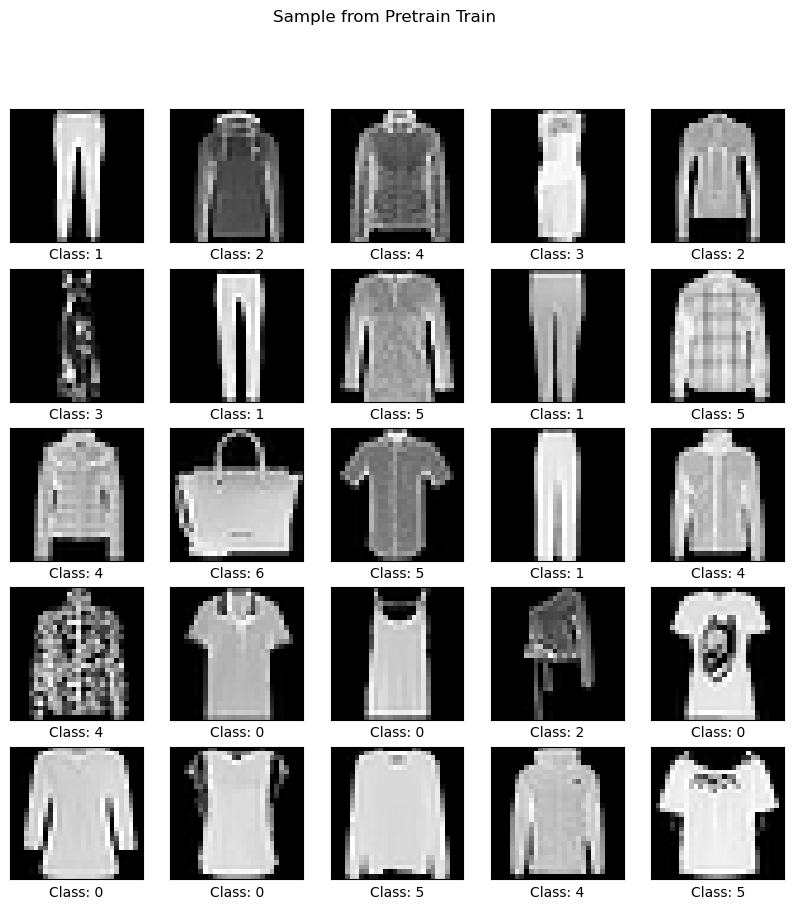

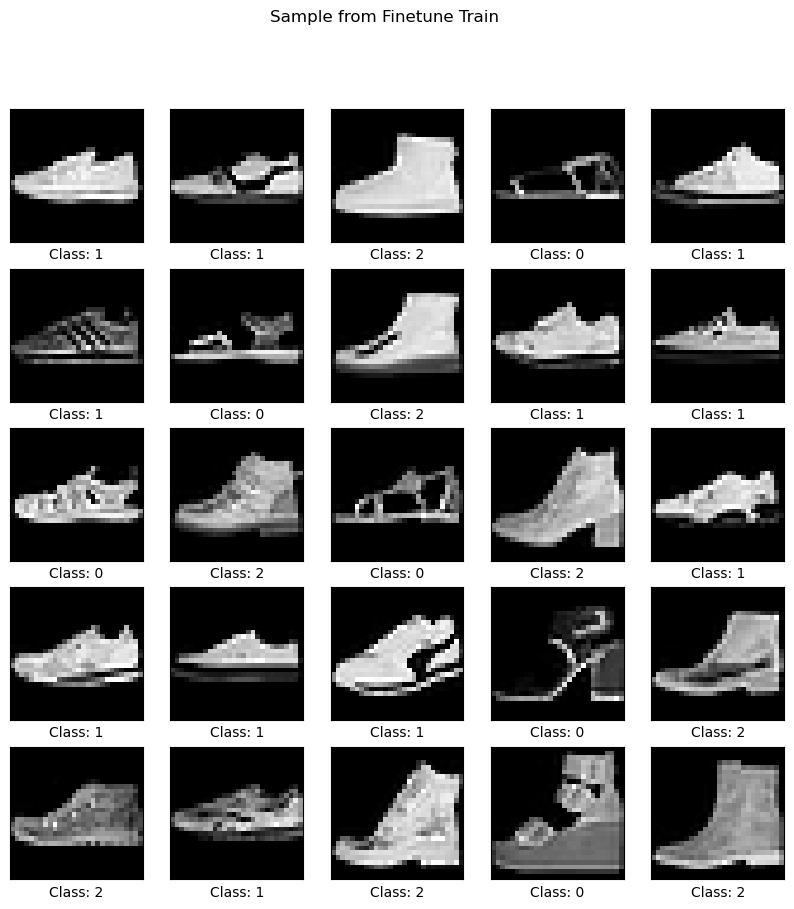

In [9]:
# Include the TransferLearningFashionMNIST and RelabeledSubset classes here

def show_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    plt.suptitle(title)
    for i in range(min(len(images), 25)):  # Display 25 images
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i][0].squeeze(), cmap='gray')
        plt.xlabel(f'Class: {labels[i].item()}')
    plt.show()

def test_data_loaders(tl_fashion_mnist):
    for loader_name, loader in [
        ("Pretrain Train", tl_fashion_mnist.pretrain_train_loader),
        ("Finetune Train", tl_fashion_mnist.finetune_train_loader),
    ]:
        images, labels = next(iter(loader))
        show_images(images, labels, f'Sample from {loader_name}')

if __name__ == "__main__":
    batch_size = 64  # Adjust as needed
    tl_fashion_mnist = TransferLearningFashionMNIST(batch_size)

    test_data_loaders(tl_fashion_mnist)